In [1]:
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import checkpoints
import matplotlib.pyplot as plt
from tifffile import imread, imsave
import torch
import torch.utils.data as dt

In [2]:
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP-JAX')
# os.chdir(r'C:\Users\ankit\Desktop\Msc AIML\msc-project\GAP-JAX')
from gap_jax.BinomDataset_JAX import BinomDataset
from  gap_jax.GAP_JAX_Trainer import Trainer, TrainState
from gap_jax.GAP_UNET_ResBlock_JAX import UN

In [3]:
data = np.concatenate((imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/trainingDataGT.tif'), imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')))

In [4]:
print(data.shape)

(2048, 512, 512)


In [5]:
def psnrToString(inp):
    if inp < 0:
        return 'm'+str(-inp)
    else:
        return str(inp)

minpsnr = -40
maxpsnr = -5

name = 'm40tom5-256x256-jax-base-v4-pls'
# CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/'
# CHECKPOINT_PATH  = "C:\\Users\\ankit\\Desktop\\Msc AIML\\Data\\checkpoints\\models\\jax\\windows\\"
CHECKPOINT_PATH = '/home/ankith/temp/test/'
CHECKPOINT_PATH, name

('/home/ankith/temp/test/', 'm40tom5-256x256-jax-base-v4-pls')

In [6]:
maxepochs = 30 # train longer for better results

# Create pytorch dataset
dataset = BinomDataset(data = data[:round(data.shape[0]*0.9)], windowSize = 256, minPSNR = minpsnr, maxPSNR = maxpsnr)
val_dataset = BinomDataset(data = data[round(data.shape[0]*0.9):], windowSize = 256, minPSNR = minpsnr, maxPSNR = maxpsnr)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True, pin_memory=False, num_workers=4, collate_fn= lambda batch: np.array(batch)) ## Changing the batch size from 32 to 16 to fit inside the gpu
val_loader = dt.DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=True,  pin_memory=False, num_workers=4, collate_fn= lambda batch: np.array(batch))

# img =  next(iter(val_loader))

# print(img.shape)

In [7]:
model = UN(channels = 1, levels=10, depth=6, start_filts=28, up_mode = 'transpose')

In [8]:
len(val_loader)

51

In [9]:
maxepochs = 25 # train longer for better results

trainer = Trainer(root_dir= os.path.join(CHECKPOINT_PATH, name),
                  gradient_clip_val=0.5,
                  epochs= maxepochs,
                  dataloader= train_loader,
                  model = model)


Using Dummy data of shape : (1, 256, 256, 1)
GPU detected with 1 Device(s).


In [28]:
import warnings
warnings.filterwarnings("ignore", message="os.fork()")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuFFT factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")
warnings.filterwarnings("ignore", message="Difference at")

trainer.train_model(train_loader= train_loader,
                    val_loader= val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Avg Loss: -0.20266510546207428




Val Loss: -0.17047272622585297



Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Avg Loss: -0.2318219691514969


Val Loss: -0.18700194358825684



: 

In [10]:
name = 'm40tom5-256x256-jax-base-v4-pls-pls'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/'
# CHECKPOINT_PATH  = "C:\\Users\\ankit\\Desktop\\Msc AIML\\Data\\checkpoints\\models\\jax\\windows\\"
# CHECKPOINT_PATH = '/home/ankith/temp/test/'
CHECKPOINT_PATH, name

('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/',
 'm40tom5-256x256-jax-base-v4-pls-pls')

In [11]:
state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, name),
                                                    target=trainer.state.params)


In [12]:
state = TrainState.create(apply_fn=trainer.state.apply_fn,
                                       params=state_dict,
                                       tx=trainer.state.tx)

In [13]:
state.params # col 1 6 row 4.09239717e -- 4.25969213e-02 - 0.12077873 - -0.1373128

{'params': {'down_convs_0': {'conv1': {'kernel': Array([[[[ 0.05252371,  0.00856764, -0.1311924 , ..., -0.08108836,
              -0.02415212, -0.15023682],
             [-0.01530965,  0.08780311,  0.12329557, ...,  0.0119256 ,
               0.1086046 ,  0.02902851],
             [ 0.05993108, -0.03381776,  0.03470314, ...,  0.03025927,
              -0.1373128 ,  0.00089518],
             ...,
             [-0.01210879, -0.05462473, -0.12354404, ...,  0.03354293,
               0.09952995, -0.02905121],
             [-0.1464087 ,  0.03536003,  0.11657611, ...,  0.1563413 ,
               0.14615542, -0.10806041],
             [-0.11584789,  0.01133839,  0.02839683, ...,  0.01475234,
              -0.06618725, -0.1247691 ]],
    
            [[-0.04754927, -0.10504861, -0.14852586, ..., -0.13912779,
               0.07600798,  0.07265963],
             [-0.00807642,  0.09962226, -0.0226881 , ...,  0.09983715,
               0.03965093,  0.13966654],
             [-0.10851679, -0.05240

In [14]:
trainer.load_model()

In [42]:
trainer.state.params

{'params': {'down_convs_0': {'conv1': {'kernel': Array([[[[ 0.05252371,  0.00856764, -0.1311924 , ..., -0.08108836,
              -0.02415212, -0.15023682],
             [-0.01530965,  0.08780311,  0.12329557, ...,  0.0119256 ,
               0.1086046 ,  0.02902851],
             [ 0.05993108, -0.03381776,  0.03470314, ...,  0.03025927,
              -0.1373128 ,  0.00089518],
             ...,
             [-0.01210879, -0.05462473, -0.12354404, ...,  0.03354293,
               0.09952995, -0.02905121],
             [-0.1464087 ,  0.03536003,  0.11657611, ...,  0.1563413 ,
               0.14615542, -0.10806041],
             [-0.11584789,  0.01133839,  0.02839683, ...,  0.01475234,
              -0.06618725, -0.1247691 ]],
    
            [[-0.04754927, -0.10504861, -0.14852586, ..., -0.13912779,
               0.07600798,  0.07265963],
             [-0.00807642,  0.09962226, -0.0226881 , ...,  0.09983715,
               0.03965093,  0.13966654],
             [-0.10851679, -0.05240

In [14]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

inpT shape (1, 512, 512, 1)
inp shape: (512, 512)
out shape: (1, 512, 512, 1)
332 0 44.3373404001294 272.0 17.0


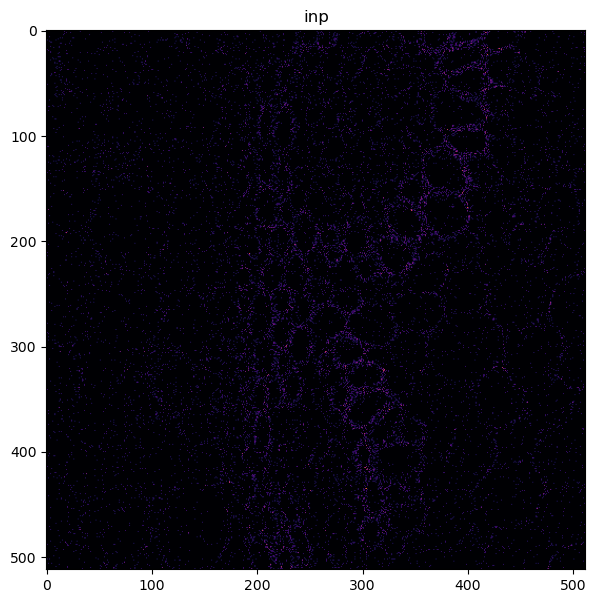

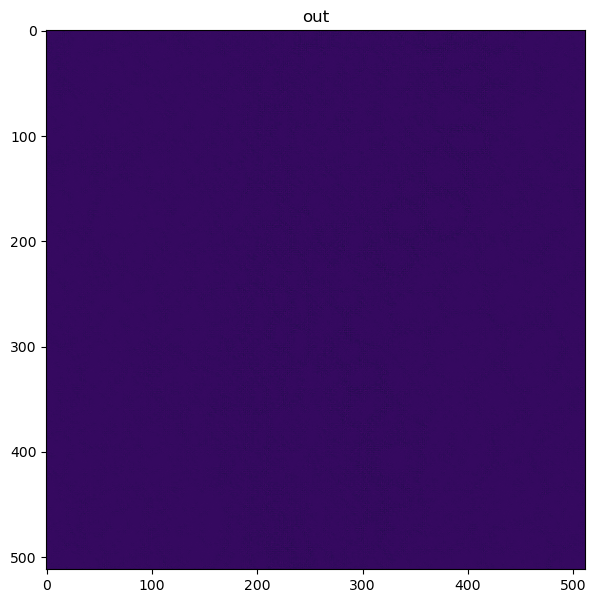

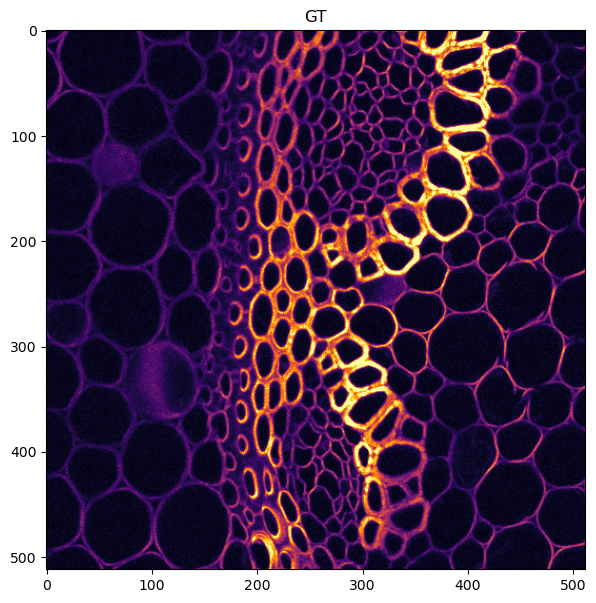

In [17]:
for inp, gt in zip(dataTest, dataTestGT):
    inpT = np.expand_dims(inp.astype(np.float32), axis = -1)
    print(f'inpT shape {inpT[None].shape}')
    # inpT = inpT/inpT.sum()
    out = jnp.exp(model.apply(state.params, inpT[None]))
    print(f'inp shape: {inp.shape}')
    print(f'out shape: {out.shape}')
    out = inp.sum() * out / out.sum()

    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99)

    plt.figure(figsize=(7,7))
    plt.imshow(inpT[:, :, 0],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    vmax = np.percentile(gt,99)
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,:,:,0],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    vmax = np.percentile(gt,99)
    plt.figure(figsize=(7,7))
    plt.imshow(gt,vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()

   

In [16]:
out.min(), inp.min(), gt.min(), out.max(), inp.max(), gt.max()

(Array(0.7235351, dtype=float32),
 0.0,
 0.0,
 Array(1.2255886, dtype=float32),
 56.50873032981246,
 9.088920968132209)

In [20]:
out.sum(), inp.sum(), (inp.sum() * out/out.sum()).sum()

(Array(262144., dtype=float32), 262144.0, Array(262144., dtype=float32))

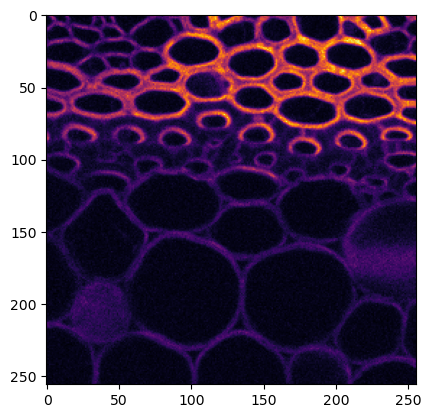

In [77]:
img = next(iter(train_loader))[-1:,:,:,:]
img.shape
plt.imshow(img[0, :,:, 0], 'inferno')

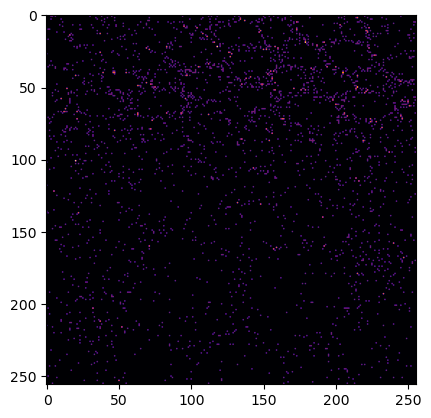

In [78]:
plt.imshow(img[0, :,:, 1], 'inferno')

In [39]:
img

array([[[[0.02913738, 0.        ],
         [0.05827476, 0.        ],
         [0.08741214, 0.        ],
         ...,
         [1.1654952 , 0.        ],
         [0.8158466 , 0.        ],
         [0.4370607 , 0.        ]],

        [[0.05827476, 0.        ],
         [0.08741214, 0.        ],
         [0.08741214, 0.        ],
         ...,
         [0.52447283, 0.        ],
         [0.2913738 , 0.        ],
         [0.20396166, 1.        ]],

        [[0.11654952, 0.        ],
         [0.05827476, 0.        ],
         [0.05827476, 0.        ],
         ...,
         [0.7284345 , 0.        ],
         [0.67015976, 0.        ],
         [0.4079233 , 0.        ]],

        ...,

        [[0.23309904, 0.        ],
         [0.20396166, 0.        ],
         [0.11654952, 0.        ],
         ...,
         [0.9323962 , 0.        ],
         [0.5536102 , 0.        ],
         [0.4370607 , 0.        ]],

        [[0.34964857, 0.        ],
         [0.2913738 , 0.        ],
         [0.

In [35]:
img[0, :,:, 0].min(), img[0, :,:, 0].max(), img[0, :,:, 0].mean(), img[0, :,:, 0].sum(), img[0, :,:, 1].min(), img[0, :,:, 1].max(), img[0, :,:, 1].mean(), img[0, :,:, 1].sum()

(0.0, 9.79016, 1.0, 65536.0, 0.0, 3.0, 0.048736572, 3194.0)

In [13]:
from flax.training import checkpoints
# CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/del/'
CHECKPOINT_PATH = "/home/ankith/temp/test/"
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
checkpoints.save_checkpoint(ckpt_dir=CHECKPOINT_PATH,
                                    target=trainer.state.params,
                                    step = 0,
                                    overwrite=True)

'/home/ankith/temp/test/checkpoint_0'

In [33]:
img = next(iter(train_loader))
img.shape

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(4, 256, 256, 2)

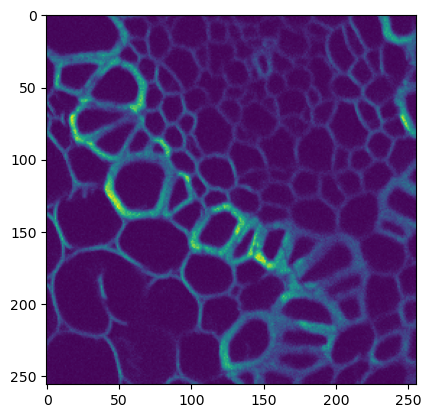

In [38]:
plt.imshow(img[1,:,:,0])

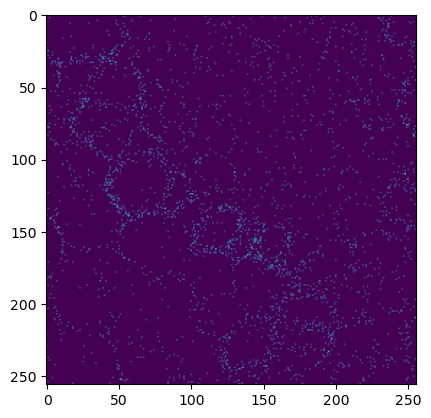

In [39]:
plt.imshow(img[1,:,:,1])

In [48]:
img = np.arange(4 * 32 * 32 * 2).reshape((4, 32, 32 ,2))

In [52]:
img[-1:, :,:,1:].shape

(1, 32, 32, 1)

In [11]:
1e6

1000000.0

In [40]:
img = np.arange(5*32*32*3).reshape((5, 32, 32 ,3))

In [41]:
img.mean(axis = (-1, -2, -3), keepdims= True), img.mean(axis = (-2, -3, -1), keepdims= True)

(array([[[[ 1535.5]]],
 
 
        [[[ 4607.5]]],
 
 
        [[[ 7679.5]]],
 
 
        [[[10751.5]]],
 
 
        [[[13823.5]]]]),
 array([[[[ 1535.5]]],
 
 
        [[[ 4607.5]]],
 
 
        [[[ 7679.5]]],
 
 
        [[[10751.5]]],
 
 
        [[[13823.5]]]]))